# HW №6 "RNA-seq data analysis"

### Teacher: Mikhail Kleimenov, Bioinformatician, BostonGene <br>e-mail: mikhail.kleimenov@bostongene.com <br>Telegram https://t.me/mike_kleimenov

## Imports

In [3]:
import numpy as np
import pandas as pd
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad
import seaborn as sns
from pathlib import Path
%matplotlib inline
sns.set_style('ticks')

## Introduction

In the assignment you will use data on gene expression and annotation of samples with cancer originated in Adrenal glands. Data were obtained from 6 different projects (7 cohorts). The goal is to explore the data, combine datasets in metacohort, harmonise it, and perform analysis with clustering data into four Adrenocortical Carcinoma (ACC) expressoin subtypes using corresponding gene signatures submited in zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002).Finally, perform survival analisys based on clustering results and predict patient survival with each subtype of adrenal cancer.


---

В задании вам будут даны экспрессии генов и аннотации пациентов с раком надпочечников (Adrenal glands) из 7 когорт (6 проектов). Задача состоит в том чтобы исследовать экпрессионные данные и аннотацию, объеденить эти когорты в метакогорту, гармонизировать ее и сделать кластерный анализ - выделить экспрессионные подтипы на основе генных сигнатур, которые опубликованны в zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002). На основе полученных кластеров посторить кривые Каплана-Майера и предсказать выживаемость пациентов с разными подтипами рака надпочесников.

## Description of some columns in annotation
<br><b>Ki67</b> - The prolifiration score based on Ki67 protein. The expression of Ki67 is strongly associated with tumor cell proliferation and growth, and is widely used in routine pathological investigation as a proliferation marker. The nuclear protein Ki67 (pKi67) is an established prognostic and predictive indicator for the assessment of biopsies from patients with cancer.<br>
<b>Weiss_score</b> - The Weiss score is prognostic factor for tumors of the adrenal cortex. <br>
<b>Purity</b> - a fraction of tumor tissue in a bulk sample. There are fractions of tumor tissue and normal tissue in each bulk sample.<br>
<b>Ploidy</b> - an average ploidy of all chromosomes over genome.

## Task №1 (0 points)
Read gene expression data and sample annotation

---

Прочитайте экспрессионные данные и аннтацию

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# reading expressions

datasets_drive_id = {
'GSE33371' : '1lBf74e_SLGIfrmmDWkO2DJAQlqiaJojv',    # GPL570 platform
'GSE19750_1' : '184cbgRbT3A__Nql6oXVlew7-UDXmFRLZ',  # GPL570 platform, batch 1
'GSE19750_2' : '1QCLliXnmcava4M37n9ZtMLJIbxZ8cxUr',  # GPL570 platform, batch 2    
'GSE90713' : '1zVNq6_HJyjvzA4RI9wJytcY16jOJiLVo',    # GPL15207 platform
'ACC_TCGA' : '1YgGHY83A_wdx5123zVQOeLdtGbNBoQB3',    # RNA-seq, classic PolyA RNA enreachment protocol
'GSE76019' : '18MeT_SeVR649851m1XlfNLS7gOC6dwz4',    # GPL13158 platform
'PMC9066577' : '1jToWuYq1sgHeLHoDqPnH8ibURnA9Uns6'   # RNA-seq, 3MACE, subtype of PolyA rna enreachment protocol
}

datasets = datasets_drive_id.keys()
expression_file_names = {ds:'{}_expr.tsv'.format(ds) for ds in datasets}

expressions = dict()
for key, value in datasets_drive_id.items():
  downloaded = drive.CreateFile({'id' : value}) 
  downloaded.GetContentFile(expression_file_names[key]) 
  expressions[key] = pd.read_csv(expression_file_names[key], index_col = 0,sep='\t').T

# reading annotation

annotation_drive_id = '1zukJtDDm8XGRgv-dayr_Log3m65sYi2a'
annotation_file_name = 'annotation.csv'

downloaded = drive.CreateFile({'id' : annotation_drive_id}) 
downloaded.GetContentFile(annotation_file_name) 
annotation = pd.read_csv(annotation_file_name, index_col = 0)

## Task №2 (0.5 point)

Explore the annotation. Briefly describe the data (columns) that are presented in the annotation. What diagnoses are represented in the annotation? Provide a short description of each unique item in diagnosis column. How many patients with each diagnosis are listed in the annotation? Patients with what stage of cancer are the most in the annotation? Plot purity distibution ('Purity' column).

---
Исследуйте аннотацию. В общих словах опишите какие данные там представленны. Пациенты с какими диагнозами собраны в этих когортах? Сколько пациентов с каждым из диагнозов? Пациентов в какой стадии рака больше всего? Постройте гистограмму распределения Purity. 


In [6]:
annotation.head()

,Patient,type,Cohort,Diagnosis,Gender,Age,beta_catenin_status,Clinical_characteristics,Stage,Weiss_score,...,OS_FLAG,PFS,PFS_FLAG,DFS,DFS_FLAG,ploidy,purity,Resection_status,Ki67,Sample_store_method
Sample,,,,,,,,,,,,,,,,,,,,,
GSM825367,Normal Adrenal Cortex 006 [NC],RNA,GSE33371,Normal,F,71,unknown,Adrenalectomy for metastatic lung carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825368,Normal Adrenal Cortex 063 [NC],RNA,GSE33371,Normal,F,58,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825369,Normal Adrenal Cortex 069 [NC],RNA,GSE33371,Normal,M,71,unknown,Adrenalectomy for renal cell carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825370,Normal Adrenal Cortex 076 [NC],RNA,GSE33371,Normal,M,44,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825371,Normal Adrenal Cortex 083 [NC],RNA,GSE33371,Normal,F,32,unknown,Adrenalectomy for ACA,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
annotation.columns

Index(['Patient', 'type', 'Cohort', 'Diagnosis', 'Gender', 'Age',
       'beta_catenin_status', 'Clinical_characteristics', 'Stage',
       'Weiss_score', 'contact_name', 'contact_institute', 'geo_accession',
       'platform_id', 'Time_treatment', 'Androgens_secretion',
       'Estrogens_secretion', 'Aldosterone_secretion', 'Cortisol_secretion',
       'Histological_type', 'OS', 'OS_FLAG', 'PFS', 'PFS_FLAG', 'DFS',
       'DFS_FLAG', 'ploidy', 'purity', 'Resection_status', 'Ki67',
       'Sample_store_method'],
      dtype='object')

In [8]:
diagnosis_counts = annotation['Diagnosis'].value_counts()
d = diagnosis_counts.index.tolist()
print(d)

['Adrenocortical_Carcinoma', 'Adrenocortical_Adenoma', 'Normal', 'Uncertain malignant potential ACT']


In [9]:
annotation['Diagnosis'].value_counts()

Adrenocortical_Carcinoma             335
Adrenocortical_Adenoma                65
Normal                                19
Uncertain malignant potential ACT      5
Name: Diagnosis, dtype: int64

In [10]:
stages_counts = annotation['Stage'].value_counts()
stages = stages_counts.index.tolist()
print(stages)

['II', 'I', 'III', 'IV', 'not applicable', 'Unknown']


In [11]:
annotation['Stage'].value_counts() # пациентов со 2 стадией рака больше всего

II                123
I                  76
III                57
IV                 52
not applicable     32
Unknown            16
Name: Stage, dtype: int64

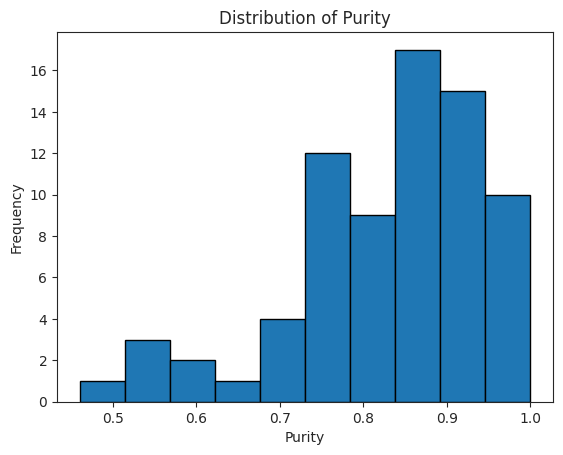

In [12]:
import matplotlib.pyplot as plt

purity_values = annotation['purity']

plt.hist(purity_values, bins=10, edgecolor='black')
plt.xlabel('Purity')
plt.ylabel('Frequency')
plt.title('Distribution of Purity')

plt.show()


## Task №3 (1 point)

Check if there is a statistically significant relationship between the patient's gender (Gender) and the Cortisol secretion level (Cortisol_secretion). The last one indicates whether the patient has an increased expression of cortisol. Take only samples for which there is information about the patient's gender ('F or 'M') and cortisol overexpression is noted ('Yes' or 'No').

---
Проверьте есть ли статистически значимая взаимосвязь между полом пациента (Gender) и переменной Cortisol_secretion, в которой отмечено замечена ли повышенная экспрессия кортизола у пациента. Для анализа берите только образцы для которых есть информация о поле пациента ('F или 'M') и повышена ли экспрессия кортизола ('Yes' или 'No')


In [13]:
from scipy.stats import chi2_contingency

In [14]:
filtered_gender = annotation[annotation['Gender'].isin(['F', 'M'])]
filtered_df = filtered_gender[filtered_gender['Cortisol_secretion'].isin(['Yes', 'No'])]

contingency_table = pd.crosstab(filtered_df['Gender'], filtered_df['Cortisol_secretion'])
print(contingency_table)

chi2, p_value, _, _ = chi2_contingency(contingency_table)

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant relationship between Gender and Cortisol_secretion.", p_value)
else:
    print("There is no statistically significant relationship between Gender and Cortisol_secretion.", p_value)

Cortisol_secretion  No  Yes
Gender                     
F                   56   86
M                   31   26
There is no statistically significant relationship between Gender and Cortisol_secretion. 0.07773452132993501


## Task №4 (1 point)

Transform each expression dataset as follows: log2(TPM+1). Exclude samples that are not in the annotation. Plot the gene expression distribution of each cohort by averaging the expressions (use sns.distplot). Print the number of genes in each cohort, the number of samples in each cohort.

---
Прологарифмируйте датасеты согласно формуле log2(TPM+1). Уберите образцы из датасетов с эксперссией для которые не встречаются в аннотации. Постройте распределение экспресии генов каждой из когорт усреднив экспрессии (можно использовать sns.distplot), выведите число генов в каждой когорте, число образцов в каждой когорте. 


<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


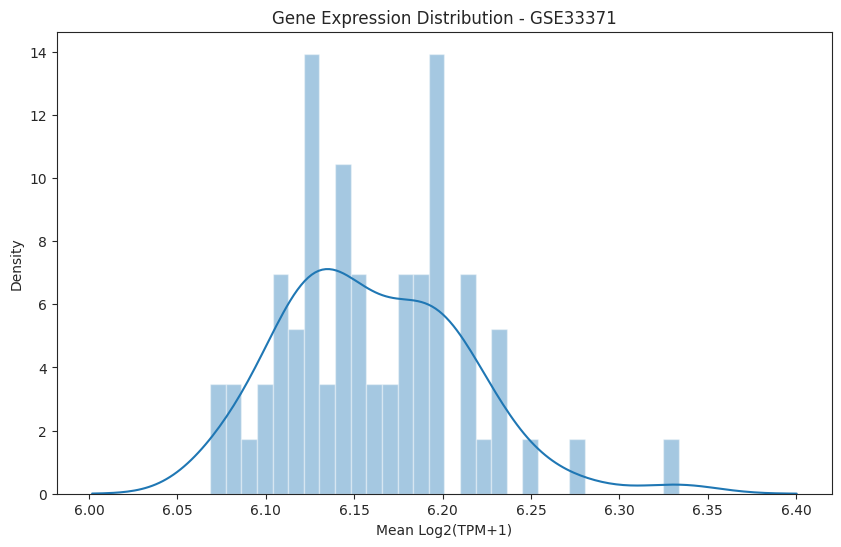

GSE33371:
Number of genes: 24442
Number of samples: 65



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


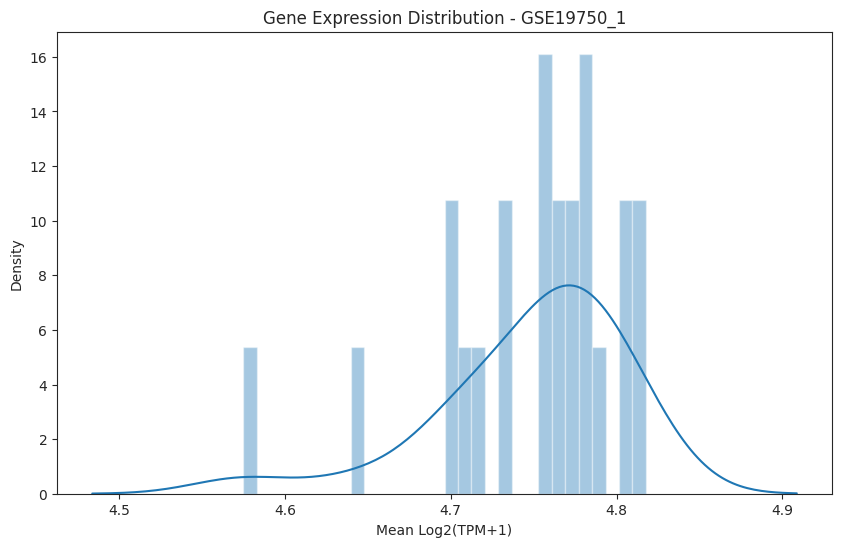

GSE19750_1:
Number of genes: 24442
Number of samples: 23



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


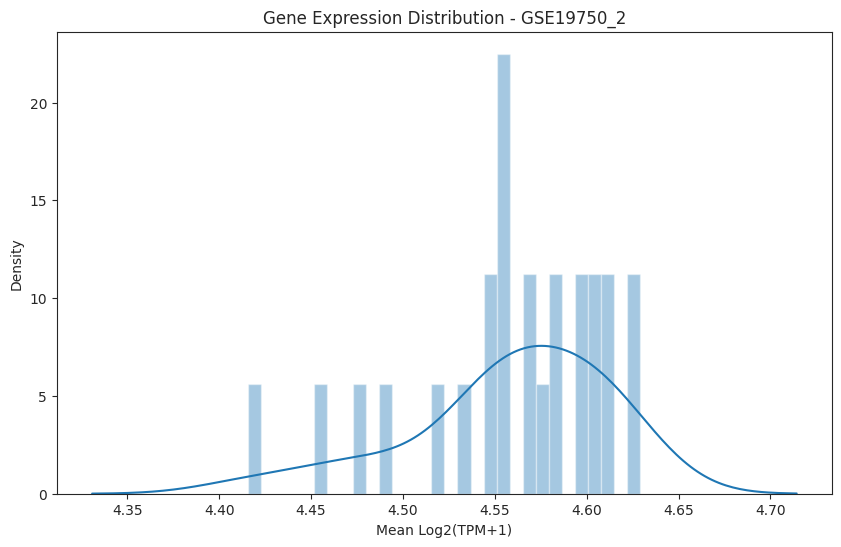

GSE19750_2:
Number of genes: 24442
Number of samples: 25



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


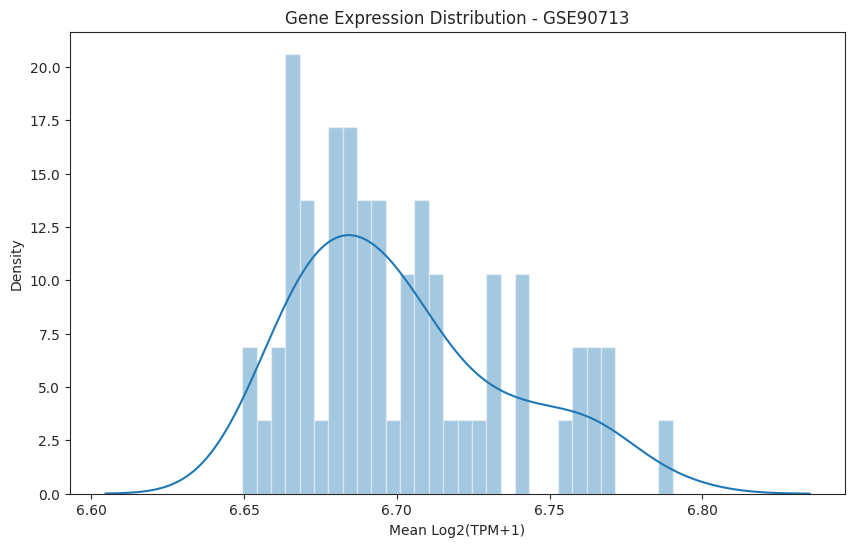

GSE90713:
Number of genes: 20151
Number of samples: 62



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


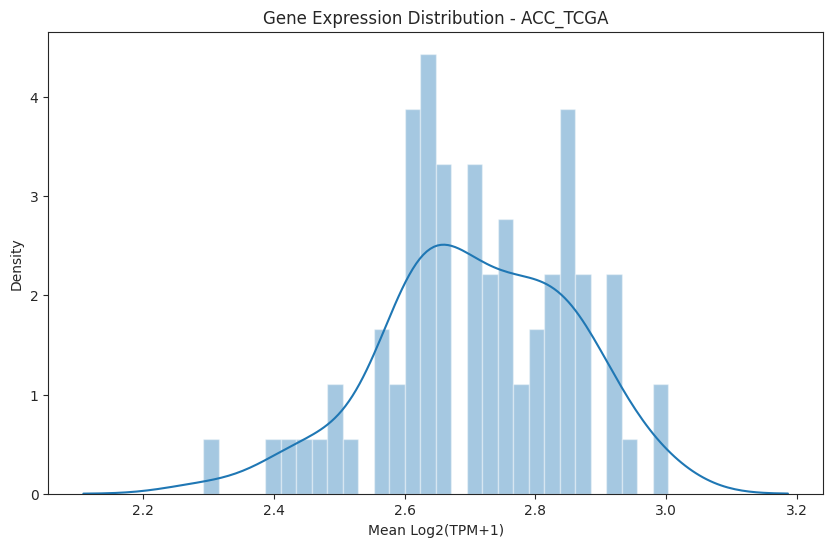

ACC_TCGA:
Number of genes: 20062
Number of samples: 76



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


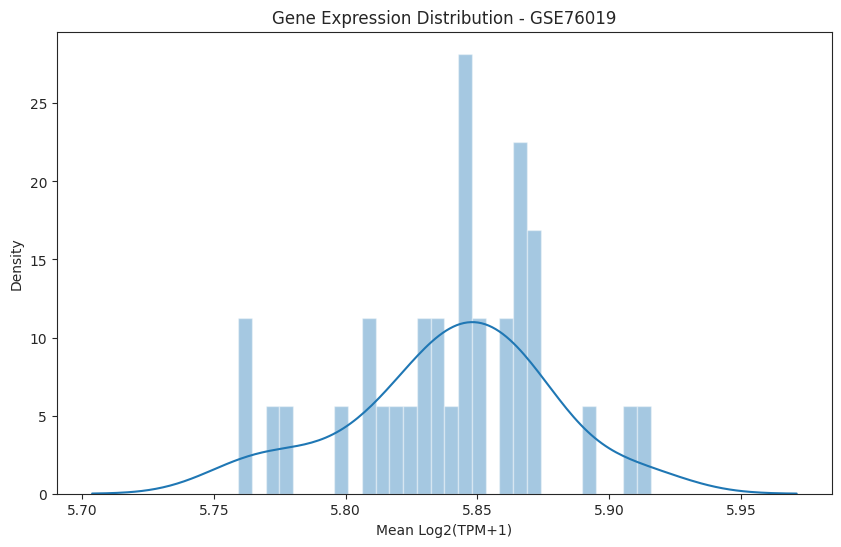

GSE76019:
Number of genes: 20940
Number of samples: 34



<ipython-input-15-adfd874bb828>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(expr_df.mean(axis=1), bins=30)


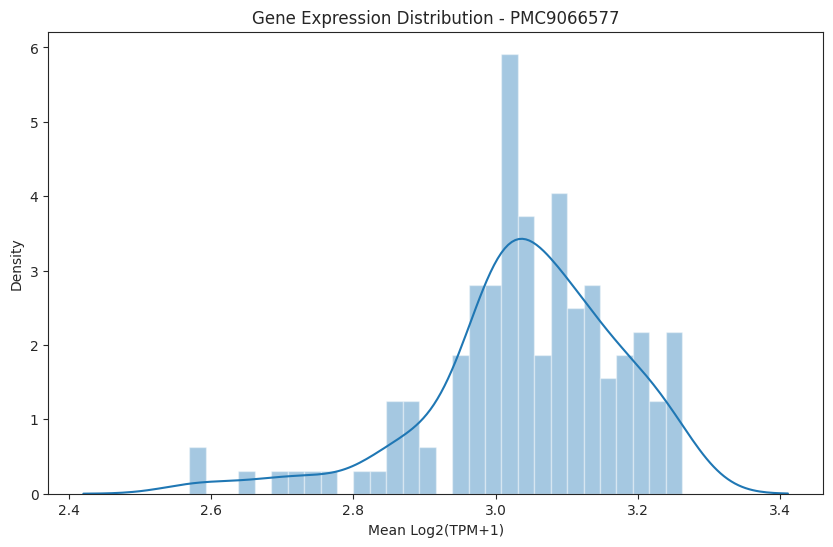

PMC9066577:
Number of genes: 17450
Number of samples: 139



In [15]:
for dataset, file_id in datasets_drive_id.items():
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(expression_file_names[dataset])
    expr_df = pd.read_csv(expression_file_names[dataset], index_col=0, sep='\t').T
    expr_df = expr_df.loc[expr_df.index.isin(annotation.index)]
    expressions[dataset] = expr_df.apply(lambda x: np.log2(x + 1))

for dataset, expr_df in expressions.items():
    plt.figure(figsize=(10, 6))
    sns.distplot(expr_df.mean(axis=1), bins=30)
    plt.title(f'Gene Expression Distribution - {dataset}')
    plt.xlabel('Mean Log2(TPM+1)')
    plt.ylabel('Density')
    plt.show()

    num_genes = expr_df.shape[1]
    num_samples = expr_df.shape[0]
    print(f'{dataset}:')
    print(f'Number of genes: {num_genes}')
    print(f'Number of samples: {num_samples}')
    print()

## Task №5 (0.5 point)

Take 2 ACC samples from the same cohort, find the 20 most expressed genes in both and list genes that are present in both lists (find intersection of two lists). Do the same thing for 2 ACC samples from different cohorts. Compare the number of genes in two resulting intersections and explain the difference.

---

Выберите 2 образца c диагнозом adrenocortical carcinoma из одной когорты, найдите 20 наиболее эксрессированных генов у каждого из них, и выведите список генов которые присутствуют в обоих полученных списках. Проделайте тоже самое для 2 образцов с тем же диагнозом из разных когорт. Сравние количесво генов в полученных пересечениях и предположите с чем это может быть связано.

In [16]:
carcinoma = annotation[annotation['Diagnosis'] == 'Adrenocortical_Carcinoma']
carcinoma['Cohort'].value_counts()

PMC9066577    91
ACC_TCGA      76
GSE90713      57
GSE76019      34
GSE33371      33
GSE19750_2    25
GSE19750_1    19
Name: Cohort, dtype: int64

In [17]:
ACC = annotation[annotation['Cohort'] == 'GSE19750_2']
ACC['Diagnosis'].value_counts()

Adrenocortical_Carcinoma    25
Name: Diagnosis, dtype: int64

In [18]:
cohort1_samples = expressions['ACC_TCGA'].sample(n=2).index
print(cohort1_samples)

cohort1_expr = expressions['ACC_TCGA'].loc[cohort1_samples]
print(cohort1_expr)

sample_indexes = cohort1_expr.sample(n=2).index
print(sample_indexes)

sample1_top_genes = cohort1_expr.loc[sample_indexes[0]].nlargest(20)
print(sample1_top_genes)
sample2_top_genes = cohort1_expr.loc[sample_indexes[1]].nlargest(20)
print(sample2_top_genes)

common_genes = set(sample1_top_genes.index).intersection(sample2_top_genes.index)

print("Common Genes:")
for gene in common_genes:
    print(gene)
print("Number of common genes: ", len(common_genes))

Index(['TCGA-OR-A5K5-01', 'TCGA-OR-A5L4-01'], dtype='object')
Gene             A1BG      A1CF       A2M     A2ML1  A3GALT2    A4GALT  \
TCGA-OR-A5K5-01   0.0  0.030428  5.634211  0.102595      0.0  2.668621   
TCGA-OR-A5L4-01   0.0  0.007057  7.874384  0.469588      0.0  3.767030   

Gene                A4GNT      AAAS      AACS     AADAC  ...     ZWINT  \
TCGA-OR-A5K5-01  0.024987  6.105440  6.221841  0.485586  ...  3.813305   
TCGA-OR-A5L4-01  0.040778  5.858327  6.075939  0.392873  ...  3.807850   

Gene                 ZXDA      ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX  \
TCGA-OR-A5K5-01  0.434122  0.956867  2.911494  0.111019  2.441388  6.461326   
TCGA-OR-A5L4-01  1.539916  2.159036  3.202497  0.036631  3.129268  5.502755   

Gene                ZZEF1      ZZZ3        pk  
TCGA-OR-A5K5-01  2.412041  0.853044  2.542700  
TCGA-OR-A5L4-01  2.400626  2.283437  2.912315  

[2 rows x 20062 columns]
Index(['TCGA-OR-A5K5-01', 'TCGA-OR-A5L4-01'], dtype='object')
Gene
SPRR1A    14.0541

In [19]:
dif_cohort1_sample = expressions['GSE76019'].sample(n=1).index
print(dif_cohort1_sample)

dif_cohort2_sample = expressions['GSE19750_2'].sample(n=1).index
print(dif_cohort2_sample)

dif_cohort1_expr = expressions['GSE76019'].loc[dif_cohort1_sample]
dif_cohort2_expr = expressions['GSE19750_2'].loc[dif_cohort2_sample]
sample1_index = dif_cohort1_expr.index
sample2_index = dif_cohort2_expr.index

sample1_top_genes = dif_cohort1_expr.loc[sample1_index[0]].nlargest(20)
print(sample1_top_genes)
sample2_top_genes = dif_cohort2_expr.loc[sample2_index[0]].nlargest(20)
print(sample2_top_genes)

common_genes = set(sample1_top_genes.index).intersection(sample2_top_genes.index)

print("Common Genes:")
for gene in common_genes:
    print(gene)
print("Number of common genes: ", len(common_genes))

Index(['GSM1972890'], dtype='object')
Index(['GSM1094071'], dtype='object')
Gene_symbol
SH3KBP1         13.916303
DLK1            13.776285
DCAF6           13.457078
TPT1            13.401233
EEF1A1          13.354825
UBC             13.342033
RPS18           13.263029
LOC100288418    13.253633
RPL41           13.223454
RPL32           13.216679
HUWE1           13.212564
RPL7A           13.212135
IGF2            13.209867
INS-IGF2        13.209867
RPL37A          13.145497
RPS11           13.107132
RPL13A          13.105153
RPL13           13.100775
RPS6            13.093115
RPL23A          13.084160
Name: GSM1972890, dtype: float64
Gene_symbol
TMEFF2          14.789732
LOC101928826    14.235363
TPT1            14.235363
RPL41           14.151736
RPL37A          14.069953
ND6             14.049059
EEF1A1          14.015306
MALAT1          14.015161
LOC100506248    13.974953
LOC728026       13.974953
MIR1244-1       13.974953
MIR1244-2       13.974953
MIR1244-3       13.974953
PTMA     

The number of shared genes is greater in samples from the same cohort. Samples from the same cohort may be exposed to similar environmental factors that affect the expression of certain genes. Samples from the same cohort may have greater genetic similarity. If certain genes are characteristic of that cohort, there is a chance that they will be found in both samples.

## Task №6 (1 point)

Display samples from 'PMC9066577' cohort by making PCA-plot (Principal Component 1 vs Principal Component 2) with 'plot_PCA' function using gene expression as sample properties and data from annotation for coloring samples (plot_PCA 'hue' function parameter). For instance, the following colomns from annotation can be used for colouring samples:: cancer type (Diagnosis), cancer stage (Stage), histological subtype (Histological_type), Ki67 score, whether the patient has an increased level of cortisol secretion (Cortisol_secretion). Which of these columns better explains the grouping of samples on the plot?

---

Постройте PCA-plot для всей когорты 'PMC9066577' (Principal Component 1 vs Principal Component 2) с помощью функции plot_PCA, используя экспрессию генов как свойства образцов и данные из аннотации для расраски образцов в разные цвета (параметр функции plot_PCA 'hue'). Пример данных из аннотации по которым можно покрасить график: вид рака (Diagnosis), стадия рака (Stage), гистологический подтип (Histological_type), Ki67 score, повышен ли у пациента уровень секреции кортизола (Cortisol_secretion). Какие из этих параметров лучше объясняют группировку образцов на графике?

In [20]:
def plot_PCA(data, hue = None, size = (6,6), dot_size = 30):
    '''
    dependances: PCA from sklearn.decomposition and sns.scatterplot from seaborn
    
    Parameters
    ----------
    data: pandas.DataFrame
        a dataframe containing expression data, where rows are genes and columns are samples
    hue: a list 
        an annotation data vector for coloring dots on the plot
    size: a tuple
        plot width and height
    dot_size: int
        size of the dots on the plot
    '''
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(data.T)
    pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
    plt.figure(figsize = size)
    x_label = 'PCA Component 1 explained {}% of variance'.format(round(pca.explained_variance_ratio_[0] * 100, 1))
    y_label = 'PCA Component 2 explained {}% of variance'.format(round(pca.explained_variance_ratio_[1] * 100, 1))
    fig = sns.scatterplot(data = pca_expr_df, x = 'PC1', y = 'PC2', hue = hue, s=dot_size)#, linewidth=0)
    if hue != None:
        fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    fig.set(xlabel = x_label, ylabel = y_label)
    plt.show()

In [21]:
common_samples = set(expressions['PMC9066577'].T.columns).intersection(annotation.T.columns)
filtered_expressions = expressions['PMC9066577'].T[common_samples]
print(filtered_expressions.shape)
filtered_annotation = annotation[annotation.T.columns.isin(common_samples)]
print(filtered_annotation.shape)

(17450, 139)
(139, 31)


<ipython-input-21-24a8db442067>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_expressions = expressions['PMC9066577'].T[common_samples]


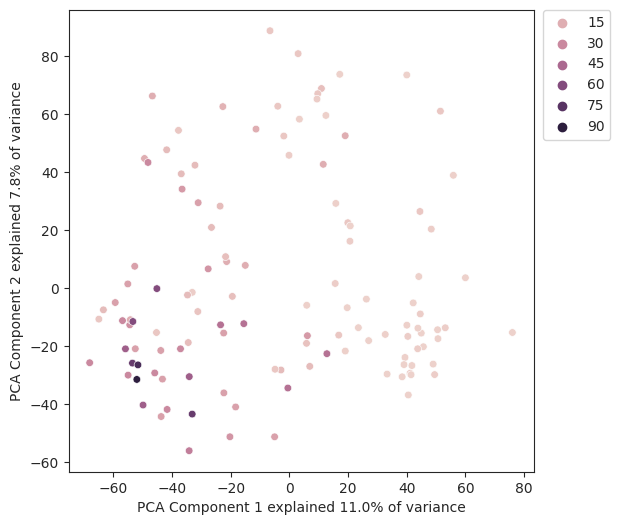

In [22]:
plot_PCA(expressions['PMC9066577'].T, hue = filtered_annotation['Ki67'].tolist(), size = (6,6), dot_size = 30)

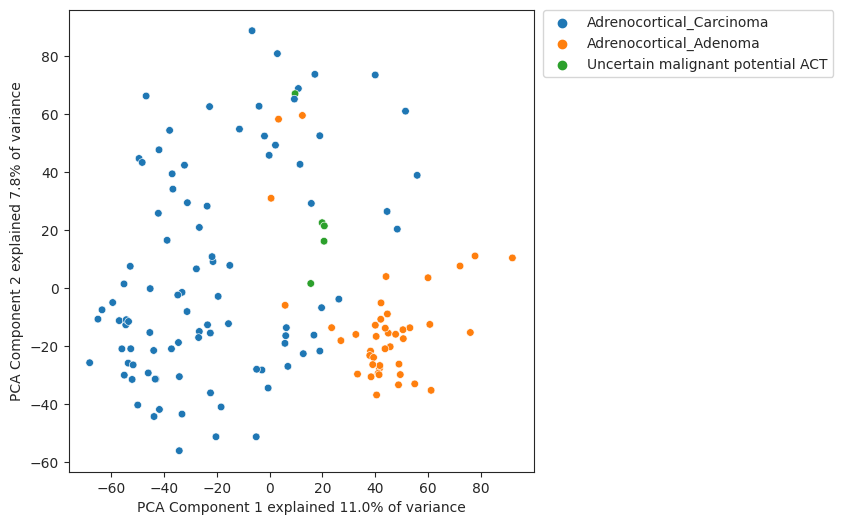

In [23]:
plot_PCA(expressions['PMC9066577'].T, hue = filtered_annotation['Diagnosis'].tolist(), size = (6,6), dot_size = 30)

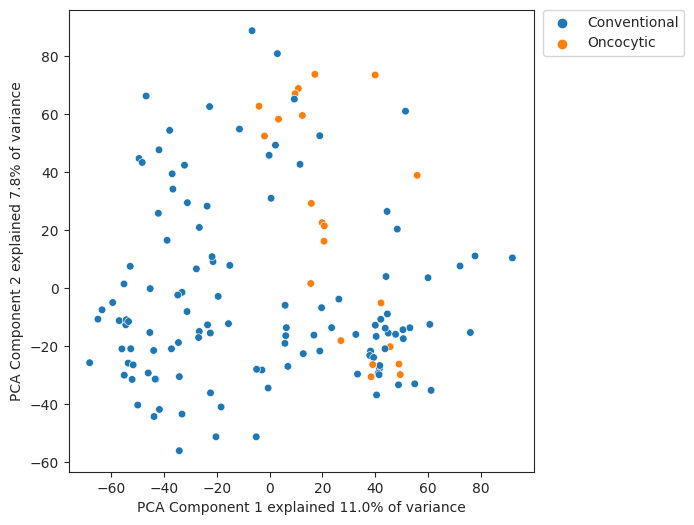

In [24]:
plot_PCA(expressions['PMC9066577'].T, hue = filtered_annotation['Histological_type'].tolist(), size = (6,6), dot_size = 30)

Diagnosis, Histological_type, Ki67 parameters better explain the grouping of samples on the plots

## Task №7 (1 point)

Join all expression data into one dataframe. Keep only samples that are in the annotation, and exclude genes that filled with NA values. Print the number of resulting genes and samples. Make a PCA plot on joint data with sample coloring using the Diagnosis and Cohort columns from the annotation. Briefly describe the resultion plot and explain why the samples are grouped this way.

---
Объедените данные экспрессий в один датафрейм (не забудьте удалить гены в которых есть значения NA и убрать образцы которых нет в анотации). Сколько всего генов по которым есть данные во всех образцам? Постройте PCA-plot и покрасьте образцы с помощью колонок Diagnosis и Cohort из аннотации. Опишите групировку образцов на графиках и объясните.


In [25]:
annotationT = annotation.T
annotationT.shape

(31, 424)

In [26]:
combined_expression = pd.DataFrame()
for key, value in expressions.items():
    combined_expression = pd.concat([combined_expression, value])

In [27]:
print(combined_expression.shape)

(424, 30899)


In [28]:
combined_expressionT = combined_expression.T
combined_expressionT

,GSM825367,GSM825368,GSM825369,GSM825370,GSM825371,GSM825372,GSM825373,GSM825374,GSM825375,GSM825376,...,ACT-122,ACT-123,ACT-124,ACT-125,ACT-126,ACT-127,ACT-128,ACT-129,ACT-130,ACT-131
A1BG,2.154123,2.154123,2.154123,2.154123,2.154123,2.144747,2.154123,2.154123,2.154123,2.154123,...,2.179526,0.000000,0.584423,0.787134,0.338470,0.000000,0.662427,0.000000,3.719341,0.123437
A1BG-AS1,2.590154,2.480771,2.590154,3.111381,2.773042,2.590154,2.594926,2.590154,2.561296,2.590154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,2.156008,2.156008,2.522069,2.552960,2.156008,2.156008,2.156008,2.156008,2.156008,2.889439,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,13.369641,13.753280,13.134988,12.833672,13.022241,12.713602,12.842655,12.883856,12.976246,12.970892,...,6.887282,8.105660,7.786632,6.207605,7.979089,7.812254,7.236365,8.675077,6.890698,6.126068
A2M-AS1,6.561435,6.955550,5.670278,5.848657,6.771931,6.789822,5.225997,4.268551,6.149148,6.543043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.133058,5.808216,5.128944,5.231235,5.418150,5.280289,4.723467,5.624080,5.632280,5.548904
ZNF888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.159780,0.000000,2.580686,2.739302,2.987408,0.000000,0.448640,3.116746,3.500366,1.976501
ZNRD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.912525,3.212803,4.442126,3.947525,4.219424,4.083063,4.205455,4.173988,3.080146,2.981059
ZSWIM9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.433937,4.553229,3.022227,4.310472,3.942957,3.419751,4.078747,3.308165,4.311817,4.669516


In [29]:
columns_to_keep = annotationT.columns
combined_expression = combined_expressionT[columns_to_keep]
combined_expression.replace('NaN', float('nan'), inplace=True)
combined_expression = combined_expression.dropna(axis=0)

print(combined_expression.shape)
print("Количество генов, которые есть во всех образцах: ", combined_expression.shape[0])

(14870, 424)
Количество генов, которые есть во всех образцах:  14870


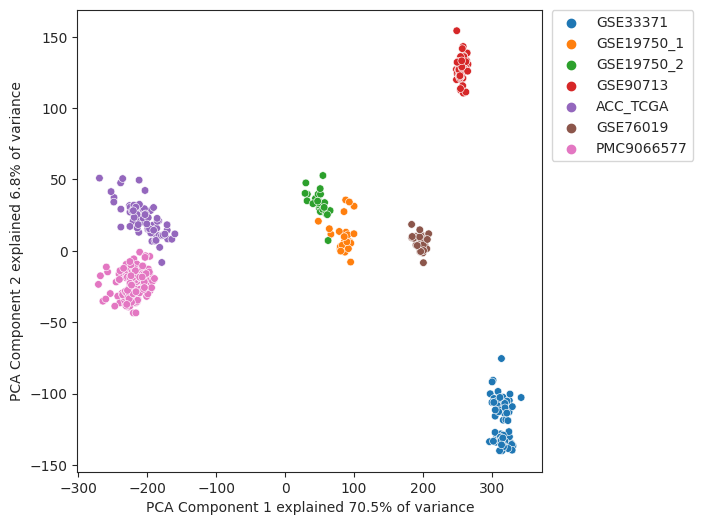

In [30]:
plot_PCA(combined_expression, hue = annotation['Cohort'].tolist(), size = (6,6), dot_size = 30)

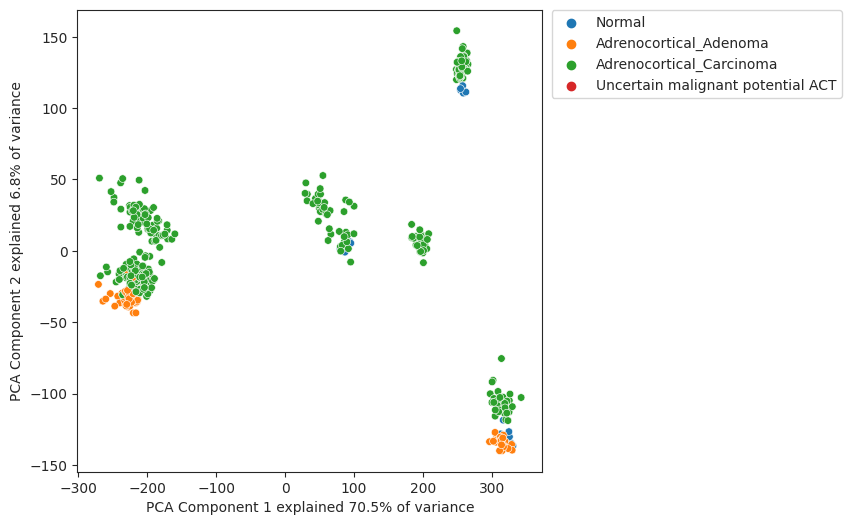

In [31]:
plot_PCA(combined_expression, hue = annotation['Diagnosis'].tolist(), size = (6,6), dot_size = 30)

## Task №8 (1 point)
Save the expressions of all Adrenocortical carcinoma samples in a separate data frame. Calculate gene signature scores using the cacl_sign_scores function (the list of genes for each signature will be stored in the expr_signs variable after running the cell below). Transform the scores using the median_scaling function (over scores, not over samples) and plot the PCA (PC1 vs PC2) using the scores as sample properties. 

---

Сохраните в отдельный датафрейм экспрессию всех образов с диагнозом Adrenocortical carcinoma. Используя функцию cacl_sign_scores, рассчитайте скоры экспрессионных сигнатур для кажлого образца (после запуска ячеек ниже, сигнатуры будут сохранены в переменной expr_signs). Отшкалируйте данные используя функцию median_scaling (по скорам, не по образцам), постройте PCA плот, используя расчитанные скоры как свойства образцов. 

In [74]:
signatures_file = 'TCGA_expr_profiles.csv'
signatures_drive_id = '195vZN8IFsZ9jDsgeuool9NHI6T_axxb9'

downloaded = drive.CreateFile({'id': signatures_drive_id}) 
downloaded.GetContentFile(signatures_file) 
sign_data = pd.read_csv(signatures_file, sep = ';', skiprows=7) 

tcga_nmf_clusters = {4 : 'steroid-phenotype-low+proliferation',
1 : 'steroid-phenotype-high+proliferation',
2 : 'steroid-phenotype-low',
3 : 'steroid-phenotype-high'}

expr_signs = dict()
for f in np.unique(sign_data.loc[:,'NMF-factor']):
    expr_signs[tcga_nmf_clusters[f]] = list(sign_data.loc[sign_data['NMF-factor'] == f,:].GeneSymbol)

In [76]:
sign_data

,GeneSymbol,GeneID,NMF-factor,tStat,pValue,tStat.1,pValue.1,tStat.2,pValue.2,tStat.3,pValue.3
0,ACAT2,39,1,0.37,0.716000,4.39,0.000036,-4.07,1.140000e-04,-0.83,0.412000
1,LPA,4018,1,0.88,0.381000,4.27,0.000057,-4.35,4.120000e-05,-1.29,0.203000
2,SPRR2B,6701,1,-1.52,0.132000,4.99,0.000004,-2.65,9.730000e-03,-0.19,0.848000
3,HSD3B2,3284,1,1.92,0.058300,4.52,0.000022,-5.48,5.230000e-07,-2.21,0.029900
4,AQP2,359,1,0.41,0.685000,3.69,0.000415,-3.99,1.500000e-04,0.03,0.978000
...,...,...,...,...,...,...,...,...,...,...,...
146,TNFSF12-TNFSF13,407977,4,-2.27,0.025800,-0.71,0.477000,1.80,7.630000e-02,2.40,0.018900
147,UBD,10537,4,-3.77,0.000326,-0.64,0.527000,2.20,3.060000e-02,4.50,0.000024
148,CPXM1,56265,4,-1.91,0.059900,-1.52,0.132000,1.75,8.480000e-02,3.58,0.000600
149,CD3D,915,4,-3.59,0.000583,-2.29,0.024700,4.01,1.410000e-04,4.07,0.000115


In [33]:
print(sum(1 for v in expr_signs.values()))
print([len(expr_signs[x]) for x in expr_signs if isinstance(expr_signs[x], list)])
print(sum([len(expr_signs[x]) for x in expr_signs if isinstance(expr_signs[x], list)]))

4
[36, 39, 38, 38]
151


In [34]:
def cacl_sign_scores(data, gene_sets, rank_method='max'):
    '''
    :param data: pd.DataFrame, DataFrame with samples in columns and genes in rows
    :param gene_sets: dict, with signature names in keys and gene lists in values
    :param rank_method: str, default 'max', how to rank the group of records that have the same value, 
        type in cell "??pd.DataFrame.rank" for detailes, 'method' parameter
    '''
    processes = pd.DataFrame(0, index = expr_signs.keys(), columns = data.columns)
    data_ranked = data.rank(method=rank_method, na_option='bottom')
    
    for gs_name in list(gene_sets.keys()):
        genes = gene_sets[gs_name]
        common_genes = list(set(genes).intersection(set(data_ranked.index)))
        if not len(common_genes):
            continue
        else:
            sranks = data_ranked.loc[common_genes,:]
            scores = (sranks**1.25).sum() / (
                sranks**0.25).sum() - (len(data_ranked.index) - len(common_genes) + 1) / 2
            processes.loc[gs_name, scores.index] = scores
    if processes.all().sum() == 0:
        print('WARNING: returning zero dataframe.')
    return processes

In [35]:
def median_scaling(df, clip=None):
    '''
    :param df : pandas.DataFrame, where rows are samples and columns are genes
    :param clip: float, default 'None', symmetrically clips the scaled data to the value
    =======================================================================================
    mad function from statsmodels.robust.scale - The Median Absolute Deviation along given axis of an array 
    '''
    median = 1.0 * df.median()
    madv = 1.0 * mad(df)
    df_out = df.sub(median).div(madv)
    if clip is not None:
        return df_out.clip(-clip, clip)
    return df_out

In [36]:
merged_sample_names = combined_expression.columns.tolist()
annotation_sample_names = annotationT.columns.tolist()
common_sample_names = list(set(merged_sample_names) & set(annotation_sample_names))
merged_with_diagnosis = pd.concat([combined_expression.T, annotation], axis=1)
ACC = merged_with_diagnosis.loc[merged_with_diagnosis['Diagnosis'] == 'Adrenocortical_Carcinoma']
ACC


,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,...,OS_FLAG,PFS,PFS_FLAG,DFS,DFS_FLAG,ploidy,purity,Resection_status,Ki67,Sample_store_method
GSM825399,2.154123,2.156008,13.023333,2.186015,2.937940,9.384500,11.985024,13.426357,2.144747,2.147331,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825400,2.144747,2.156008,11.873233,2.186015,3.940956,9.501052,10.738492,7.034037,2.144747,3.012007,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825401,2.154123,2.156008,12.747186,2.186015,3.940956,9.187084,12.494855,6.666259,2.144747,2.252892,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825402,3.821751,2.363672,12.213260,3.029806,4.589068,9.944879,10.793447,6.229027,2.144747,3.012007,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825403,2.936721,5.169400,12.920717,2.186015,4.138965,9.469080,10.296836,6.809419,2.144747,3.012007,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACT-127,0.000000,0.000000,7.812254,3.874057,1.683151,5.080858,5.242500,0.000000,0.000000,1.316704,...,1,NaN,NaN,16.0,1.0,NaN,NaN,R0,20.0,FFPE
ACT-128,0.662427,0.000000,7.236365,1.979769,3.019138,5.325916,5.356016,0.000000,0.000000,0.527867,...,0,NaN,NaN,3.0,1.0,NaN,NaN,RX,30.0,FFPE
ACT-129,0.000000,0.000000,8.675077,0.130563,2.473317,4.963352,6.385460,1.794226,0.000000,2.881156,...,1,NaN,NaN,2.0,1.0,NaN,NaN,RX,60.0,FFPE
ACT-130,3.719341,0.000000,6.890698,0.000000,2.250899,5.147392,6.767125,2.504837,0.000000,0.000000,...,1,NaN,NaN,5.0,1.0,NaN,NaN,R0,30.0,FFPE


In [37]:
sign_data = ACC.T.iloc[:14870]
sign_data.shape

(14870, 335)

In [38]:
result_scores = cacl_sign_scores(sign_data, expr_signs, rank_method='max')
result_scores

,GSM825399,GSM825400,GSM825401,GSM825402,GSM825403,GSM825404,GSM825405,GSM825406,GSM825407,GSM825408,...,ACT-122,ACT-123,ACT-124,ACT-125,ACT-126,ACT-127,ACT-128,ACT-129,ACT-130,ACT-131
steroid-phenotype-high+proliferation,-373.938252,-1792.313636,379.296150,-2238.364194,-808.023606,-1651.539521,-730.907090,-3934.578327,-1300.747961,-2351.470505,...,-2409.394618,-414.372761,1919.497065,-3209.852660,-1847.279521,-1545.030073,-2032.367216,178.830232,950.033166,1433.240902
steroid-phenotype-low,-652.355723,-547.416617,-1980.373347,572.369297,-2135.796448,-2927.072541,-913.203231,1802.021409,-2709.299849,-1338.383985,...,2439.460066,-971.059455,-1607.378468,366.640367,1980.110677,-1256.066522,1702.194421,-2200.889864,-496.593227,-2139.474584
steroid-phenotype-high,-3275.794201,-877.148931,-2685.731675,-711.515769,322.544055,1401.466708,-25.713224,-817.704117,479.177919,1022.292051,...,-21.219460,1381.888244,-1429.955830,-199.842218,-1226.432150,3338.789586,-370.806489,-2385.274305,-2041.287470,-1428.757908
steroid-phenotype-low+proliferation,-3753.272932,-4071.456468,-3753.465310,-4060.169201,-3235.501171,-3491.437505,-3645.585592,-3771.477247,-3716.896826,-2349.011454,...,-2845.626153,-3069.530454,-3861.924926,-2913.715034,-3379.630431,-2625.230053,-2784.711445,-1841.891263,-2886.575953,-3976.380800


In [39]:
gene_sets = {}

for signature_name, gene_list in expr_signs.items():
    common_genes = list(set(gene_list).intersection(set(sign_data.index)))
    if len(common_genes) > 0:
        gene_sets[signature_name] = common_genes

result_scores = cacl_sign_scores(sign_data, gene_sets, rank_method='max')
result_scores

,GSM825399,GSM825400,GSM825401,GSM825402,GSM825403,GSM825404,GSM825405,GSM825406,GSM825407,GSM825408,...,ACT-122,ACT-123,ACT-124,ACT-125,ACT-126,ACT-127,ACT-128,ACT-129,ACT-130,ACT-131
steroid-phenotype-high+proliferation,-373.938252,-1792.313636,379.296150,-2238.364194,-808.023606,-1651.539521,-730.907090,-3934.578327,-1300.747961,-2351.470505,...,-2409.394618,-414.372761,1919.497065,-3209.852660,-1847.279521,-1545.030073,-2032.367216,178.830232,950.033166,1433.240902
steroid-phenotype-low,-652.355723,-547.416617,-1980.373347,572.369297,-2135.796448,-2927.072541,-913.203231,1802.021409,-2709.299849,-1338.383985,...,2439.460066,-971.059455,-1607.378468,366.640367,1980.110677,-1256.066522,1702.194421,-2200.889864,-496.593227,-2139.474584
steroid-phenotype-high,-3275.794201,-877.148931,-2685.731675,-711.515769,322.544055,1401.466708,-25.713224,-817.704117,479.177919,1022.292051,...,-21.219460,1381.888244,-1429.955830,-199.842218,-1226.432150,3338.789586,-370.806489,-2385.274305,-2041.287470,-1428.757908
steroid-phenotype-low+proliferation,-3753.272932,-4071.456468,-3753.465310,-4060.169201,-3235.501171,-3491.437505,-3645.585592,-3771.477247,-3716.896826,-2349.011454,...,-2845.626153,-3069.530454,-3861.924926,-2913.715034,-3379.630431,-2625.230053,-2784.711445,-1841.891263,-2886.575953,-3976.380800


In [40]:
transformed_scores = result_scores.T
#заменяем в датафрейме колонку с нозологией на колонки с генами этой нозологии, коэфициенты оставляем как для нозологии

for i in expr_signs:
  for j in expr_signs[i]:
    transformed_scores[j] = transformed_scores[i].values.tolist()
  transformed_scores = transformed_scores.drop(columns=i)

transformed_scores

<ipython-input-40-d1f293017be9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_scores[j] = transformed_scores[i].values.tolist()
<ipython-input-40-d1f293017be9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_scores[j] = transformed_scores[i].values.tolist()
<ipython-input-40-d1f293017be9>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

,ACAT2,LPA,SPRR2B,HSD3B2,AQP2,FAM166B,POU4F1,GREM2,GYLTL1B,CPN2,...,CD7,TPSAB1,GZMA,CCL18,TPSB2,TNFSF12-TNFSF13,UBD,CPXM1,CD3D,CD8B
GSM825399,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,-373.938252,...,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932,-3753.272932
GSM825400,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,-1792.313636,...,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468,-4071.456468
GSM825401,379.296150,379.296150,379.296150,379.296150,379.296150,379.296150,379.296150,379.296150,379.296150,379.296150,...,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310,-3753.465310
GSM825402,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,-2238.364194,...,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201,-4060.169201
GSM825403,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,-808.023606,...,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171,-3235.501171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACT-127,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,-1545.030073,...,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053,-2625.230053
ACT-128,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,-2032.367216,...,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445,-2784.711445
ACT-129,178.830232,178.830232,178.830232,178.830232,178.830232,178.830232,178.830232,178.830232,178.830232,178.830232,...,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263,-1841.891263
ACT-130,950.033166,950.033166,950.033166,950.033166,950.033166,950.033166,950.033166,950.033166,950.033166,950.033166,...,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953,-2886.575953


In [41]:
#из всех генов в sign_data.T выбираем только те, которые есть в transformed_scores, умножаем колонку с геном на колонку с коэфициентом

res_df = transformed_scores
for col in transformed_scores.columns:
  try:
    res_df[col] = transformed_scores[col].multiply(sign_data.T[col], axis="index")
  except:
    print(col)
    continue
res_df

GYLTL1B
C6orf223
CDHR5
C21orf15
NCRNA00087
AGPAT9
GPR98
GSTA2
C6orf142
C1QTNF8
BAI1
LOC642597
KLKP1
FAM155A
FBXL21
D4S234E
MGC29506
ADAM6
CCL18
TNFSF12-TNFSF13
UBD


,ACAT2,LPA,SPRR2B,HSD3B2,AQP2,FAM166B,POU4F1,GREM2,GYLTL1B,CPN2,...,CD7,TPSAB1,GZMA,CCL18,TPSB2,TNFSF12-TNFSF13,UBD,CPXM1,CD3D,CD8B
GSM825399,-5026.489956,-802.338368,-1760.574098,-4069.224483,-2884.152349,-4278.306073,-827.844023,-3462.453951,-373.938252,-3432.696319,...,-15423.398398,-13220.546215,-11451.029285,-3753.272932,-8769.372074,-3753.272932,-3753.272932,-8644.626043,-18127.139116,-8239.521033
GSM825400,-20776.951335,-3844.058398,-8438.561563,-22967.796662,-8713.917754,-18664.378136,-3950.09938,-3844.058398,-1792.313636,-8531.192454,...,-18822.339182,-14341.3174,-12685.881522,-4071.456468,-11078.057255,-4071.456468,-4071.456468,-9377.47381,-14844.98018,-8938.026042
GSM825401,4542.103259,813.494091,3696.853926,4407.382198,4319.57476,4584.633547,2458.615321,3342.1612,379.296150,2286.041565,...,-17293.327587,-13221.22385,-14003.632944,-3753.465310,-10470.210784,-3753.465310,-3753.465310,-8050.231587,-19644.685931,-8239.94336
GSM825402,-23184.113433,-4800.723771,-10939.698343,-24774.691671,-11428.324293,-8742.034772,-4933.155022,-4800.723771,-2238.364194,-13287.957265,...,-18770.158158,-14301.559078,-14484.753912,-4060.169201,-11325.754693,-4060.169201,-4060.169201,-9351.476712,-19810.375537,-8913.247222
GSM825403,-7696.469293,-1733.005802,-11363.804827,-11688.329732,-3924.605644,-7773.059427,-1780.811953,-6119.856056,-808.023606,-4378.76719,...,-13843.545702,-11396.744533,-10592.300906,-3235.501171,-9025.360954,-3235.501171,-3235.501171,-7452.082009,-17054.048421,-7102.862072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACT-127,-6071.743839,-0.0,-680.556588,-10848.195649,-0.0,-5403.999237,-0.0,-0.0,-1545.030073,-0.0,...,-0.0,-0.0,-18759.577155,-2625.230053,-0.0,-2625.230053,-2625.230053,-0.0,-5975.821172,-2520.230637
ACT-128,-9346.931474,-0.0,-1441.198254,-7892.889797,-0.0,-664.169498,-1317.469355,-0.0,-2032.367216,-0.0,...,-0.0,-0.0,-6328.202799,-2784.711445,-0.0,-2784.711445,-2784.711445,-0.0,-0.0,-0.0
ACT-129,1330.421592,0.0,468.49039,1021.680345,0.0,449.528122,0.0,865.627395,178.830232,216.777346,...,-1858.851649,-2060.901131,-0.0,-1841.891263,-0.0,-1841.891263,-1841.891263,-5562.594763,-6710.893586,-0.0
ACT-130,6644.927181,0.0,2570.676342,7441.089451,0.0,7216.508103,1727.623656,0.0,950.033166,1925.42869,...,-0.0,-0.0,-0.0,-2886.575953,-0.0,-2886.575953,-2886.575953,-0.0,-0.0,-0.0


In [42]:
scaled_scores = median_scaling(res_df, clip=None)
scaled_scores

,ACAT2,LPA,SPRR2B,HSD3B2,AQP2,FAM166B,POU4F1,GREM2,GYLTL1B,CPN2,...,CD7,TPSAB1,GZMA,CCL18,TPSB2,TNFSF12-TNFSF13,UBD,CPXM1,CD3D,CD8B
GSM825399,0.026078,-0.540681,-0.291422,0.115025,-0.92593,0.013962,-0.539901,-1.118283,0.271052,-0.786436,...,-2.157986,-1.071347,-0.738303,-0.701400,-0.483548,-0.701400,-0.701400,-0.767672,-1.944908,-1.310396
GSM825400,-1.490791,-2.977834,-1.8165,-1.797975,-2.856247,-1.564869,-2.576164,-1.252607,-0.503220,-2.094226,...,-2.782195,-1.21935,-0.939418,-1.014033,-0.788421,-1.014033,-1.014033,-0.889931,-1.456128,-1.478664
GSM825401,0.947594,0.753992,0.954913,0.973066,1.459325,0.986645,1.603452,1.276939,0.682233,0.680449,...,-2.501395,-1.071436,-1.154034,-0.701589,-0.708152,-0.701589,-0.701589,-0.66851,-2.170901,-1.310497
GSM825402,-1.722616,-3.744354,-2.387694,-1.980877,-3.755025,-0.47592,-3.21729,-1.589353,-0.746713,-3.314361,...,-2.772612,-1.2141,-1.232392,-1.002943,-0.82113,-1.002943,-1.002943,-0.885594,-2.195575,-1.472695
GSM825403,-0.231058,-1.28637,-2.484549,-0.656216,-1.270439,-0.369577,-1.161404,-2.053687,0.034091,-1.029108,...,-1.86785,-0.830505,-0.598446,-0.192660,-0.517352,-0.192660,-0.192660,-0.568723,-1.785103,-1.036576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACT-127,-0.074587,0.102186,-0.044774,-0.571173,0.029053,-0.10958,-0.0,0.1005,-0.368231,0.094067,...,0.67449,0.67449,-1.928613,0.406967,0.67449,0.406967,0.406967,0.67449,-0.135331,0.067371
ACT-128,-0.390008,0.102186,-0.218485,-0.272024,0.029053,0.410603,-0.859223,0.1005,-0.634262,0.094067,...,0.67449,0.67449,0.096029,0.250267,0.67449,0.250267,0.250267,0.67449,0.754589,0.67449
ACT-129,0.638289,0.102186,0.217639,0.63035,0.029053,0.532829,0.0,0.4052,0.572801,0.149672,...,0.333115,0.402338,1.126675,1.176642,0.67449,1.176642,1.176642,-0.253504,-0.244799,0.67449
ACT-130,1.150109,0.102186,0.697723,1.280152,0.029053,1.275486,1.126716,0.1005,0.993791,0.58795,...,0.67449,0.67449,1.126675,0.150179,0.67449,0.150179,0.150179,0.67449,0.754589,0.67449


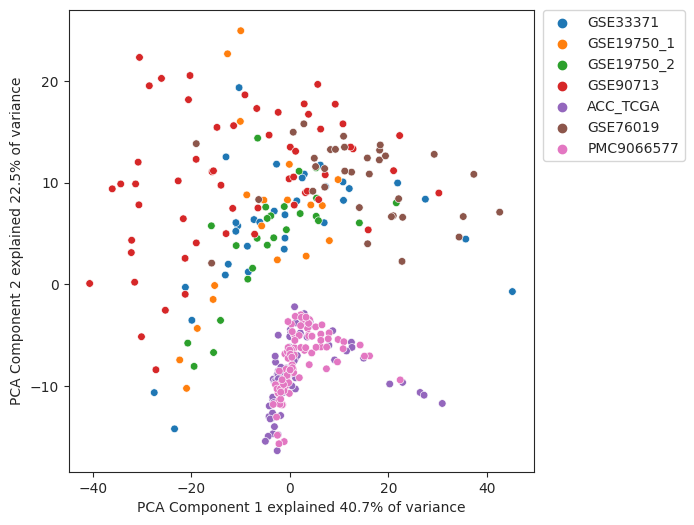

In [43]:
plot_PCA(scaled_scores.T, hue = ACC['Cohort'].tolist(), size = (6,6), dot_size = 30)

## Task №9 (2 points - 1 point for each algorithm)

Perform a cluster analysis of the dataset containig gene signatures scores using Agglomerative Clustering (Hierarchical clustering) and K-mean algorithms. Specify the number of clusters - 4 (n_clusters=4). Diaplay PCA-plot, colour samples with claster labels. <br>

Which of these algorithms is best suited for this task? (give answer based on visual inspection). For Agglomerative Clustering, try different methods for calculating the distances between samples (linkage parameter), which method shows a better result? For K-means, run a algorithm a few times and evaluate the reproducibility of the results.

---
Проведите кластерный анализ полученного в задаче 8 датаета со скорами сигнатур, используя алгоритмы Agglomerative Clustering (Иерархическая кластеризация) и K-means, n_clusters=4.  Постройте PCA plot, используя полученную разметку образцов по класетерам для раскраски образцов. 

Какой из этих алгоритмов лучше выделяет кластера (дайте ответ на основании визуальной инспекции)? Для Agglomerative Clustering попробуйте различные методы расчета растояний между образцами (параметр linkage), какой метод показывает более адекваный результат? Для K-means проведите несколько повторений и оцените воспроизводимость результатов.

---

Manuals:<br>
AgglomerativeClustering https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html<br>
K-means https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [44]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [45]:
pca = PCA(2)

df = pca.fit_transform(scaled_scores)
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


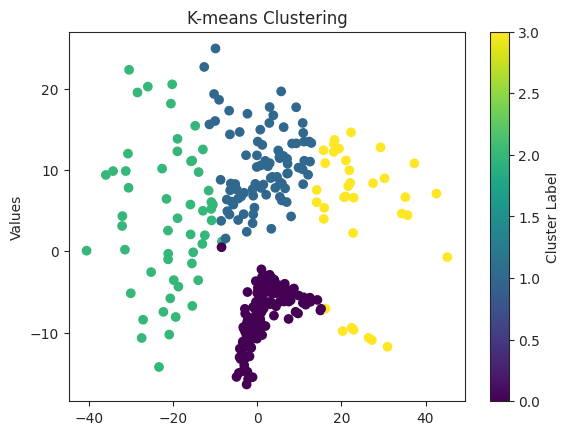

In [46]:
cluster_labels = kmeans.labels_

plt.scatter(df[:, 0], df[:, 1], c=cluster_labels, cmap='viridis')
plt.ylabel('Values')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

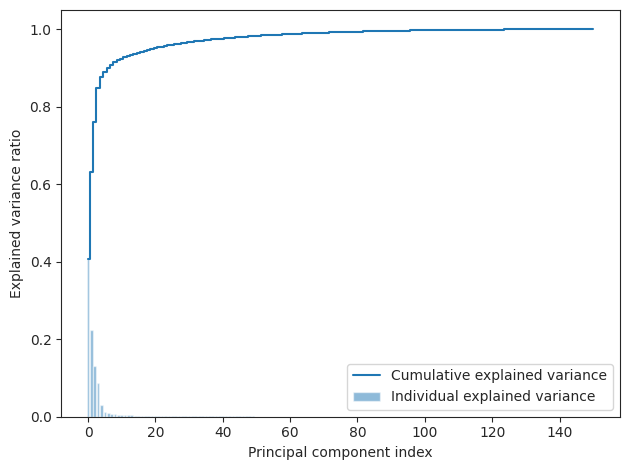

In [47]:
pca = PCA()
X_train_pca = pca.fit_transform(scaled_scores)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

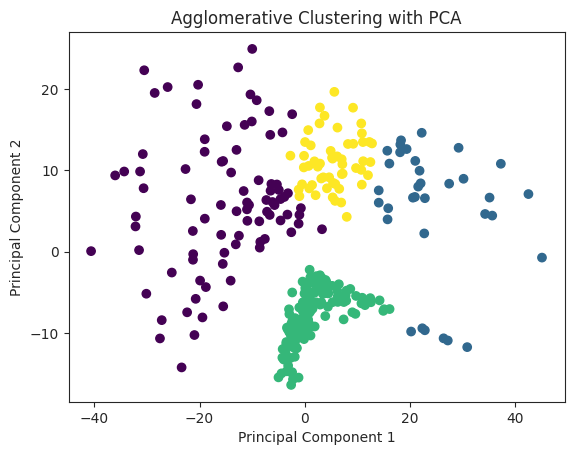

In [48]:
n_components = 2 
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(scaled_scores)

n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering with PCA')
plt.show()

## Task №10 (2 points)

Choose one of the clustering results that you think is the best. Here, the 4 found clusters represent 4 Adrenocortical carcinoma subtypes obtained using expression data. 
* Plot Kaplan-Meier curves for each of the four subtypes using the kaplanmeier package. Use the annotation columns 'OS' (number of months under observation) and 'OS_FLAG' (occurrence of event, 1 - patient decreased, 0 - patient alive), remember to remove samples with missing values (NA). How many patients are included in this survival analysis? Which subtype is associated with the worst prognosis and which one with the best? 

* Each of the 4 gene signatures characterizes one of the 4 subtypes. It is expected that the belonging of a sample to a particular subtype can be determined by the largest gene signature score (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). Based on this, determine the approximate correspondence of the obtained 4 clusters and 4 subtypes of adrenal cancer and label the curves on the Kaplan-Meier plot.
---

Выберете один из результатов кластеризации, который считаете наиболее адекватным. Четыре полученных кластера в задаче 9 это четыре подтипа Adrenocortical carcinoma, выделенных на основании экспрессионного анализа.
* Посторойте кривые Каплана-Майера для пациентов каждого из четырех подтипов используя пакет kaplanmeier. Используйте колонки из аннотации 'OS' (число месяцев под наблюденим) и 'OS_FLAG'(наступление события, 1 - пациент умер, 0 - пациент жив), не забудьте убрать образцы с пропущенными значаениями. Сколько пациентов участвуют в анализе выживаемости? Какой подтип связан с худшим прогнозом, а какой с лучшим?


* (Optional) Каждая из 4 генных сигнатур характеризует один из 4 подтипов. Ожидается, что принадлежность образца к конкретному подтипу можно определить по самому большому одноименному скору (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). На основании этого определите примерное соответствие полученных 4 кластеров и 4 подтипов рака надопчечника и подпишите кривые на графике Каплана-Майера.


---


Manual:<br>
kaplanmeier https://erdogant.github.io/kaplanmeier/pages/html/Examples.html


In [49]:
! pip install kaplanmeier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=9aed32b58a70d2564f0675a63a275850a74043600f71f9951fffc8ff8382bfb3
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [50]:
import kaplanmeier as km

In [51]:
cluster_labels = kmeans.labels_
cluster_series = pd.Series(cluster_labels, index=scaled_scores.index, name='Cluster')

print(cluster_series.value_counts())

0    161
1     86
2     53
3     35
Name: Cluster, dtype: int64


In [52]:
merged_df = ACC.merge(cluster_series, left_index=True, right_index=True)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils

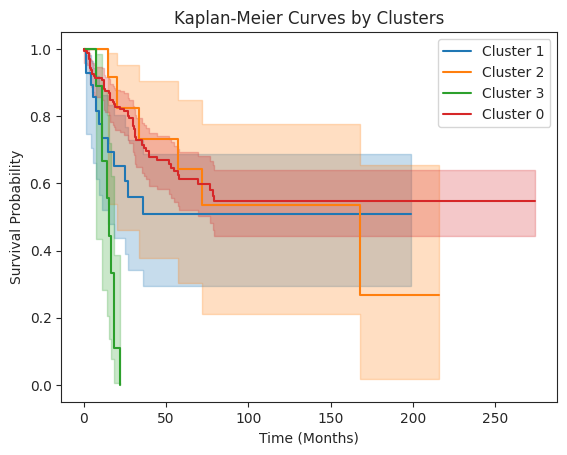

In [53]:
merged_df.dropna(subset=['OS', 'OS_FLAG'], inplace=True)

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for each cluster
clusters = merged_df['Cluster'].unique()
for cluster in clusters:
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    kmf.fit(cluster_data['OS'], cluster_data['OS_FLAG'], label=f'Cluster {cluster}')
    kmf.plot()

plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Curves by Clusters')
plt.legend()
plt.show()